In [1]:
import baltic as bt
import pandas as pd
import numpy as np
import re
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon ## for polygons
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection ## for polygons too
from matplotlib.colors import LinearSegmentedColormap ## for colour maps
from matplotlib import gridspec ## for composite figures
import matplotlib.patheffects as path_effects ## for elegant text
from IPython.display import HTML
from mpl_toolkits.mplot3d import axes3d
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch


def colourDict(data,cmap=mpl.cm.viridis):
    """
    returns a dictionary of unique data_items:colour hex code, normalised
    takes a list of items and a cmap as mpl.cm.name
    """
    cmap=cmap # default viridis
    data_unique=sorted(list(set(data))) # includes nan values as a key. That is desirable sometimes
    norm = mpl.colors.Normalize(vmin=0, vmax=len(data_unique))
    colors = [cmap(norm(value)) for value in range(len(data_unique))]
    return dict(zip(data_unique,colors))

def legend(dictionary,marker='o',markersize=15,labelspacing=1,fontsize=10,ax='',style='italic',loc='best',bbox_to_anchor=(0.5, 0.5),fontname='Arial'): # `'upper left', 'upper right', 'lower left', 'lower right'
    """ Returns a legend object from a dictionary"""
    legend_elements=[]
    for key,value in dictionary.items():
        legend_elements.append(Line2D([0],[0],marker=marker,color=value,label=key,markersize=markersize))
    leg=ax.legend(handles=legend_elements, loc=loc,labelspacing=labelspacing,prop={'size': fontsize,'style':style,'family':fontname},bbox_to_anchor=bbox_to_anchor)
    return leg

C:\Users\xtorrm\Documents\Python3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\xtorrm\Documents\Python3\lib\site-packages\numpy\.libs\libopenblas.IPBC74C7KURV7CB2PKT5Z5FNR3SIBV4J.gfortran-win_amd64.dll
C:\Users\xtorrm\Documents\Python3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
  stacklevel=1)


In [8]:
antmcct_path='./Azteca_exp_strict_ITS2_min_mcct.tre'

anttree=bt.loadNexus(antmcct_path,absoluteTime=False)
anttree.traverse_tree()
anttree.treeStats()
anttree.drawTree()


Tree height: 48.182534
Tree length: 1195.351047
strictly bifurcating tree
annotations present

Numbers of objects in tree: 579 (289 nodes and 290 leaves)



In [9]:
data=pd.read_csv('./coordinates_of_plants_and_ants.csv',sep=',')
# the localities are near the political border and there are no biogeographical barriers between the two. 
data.replace('Boyaca','Casanare')
data

# filtering out collections of plants from other species that are not included in the analyses
datatococa=data[(data['Plant']=='Tococa guianensis') | (data['Plant']=='Tococa')]
datatococa

,Plant,Ant,Collection,Department,Locality,Area (RASP),Latitude,Longitude,Altitude (m)
0,Tococa,Azteca,MFT147,Amazonas,Leticia,NaN,-4.120033,-69.956267,92.0
1,Tococa,Azteca,MFT148,Amazonas,Leticia,NaN,-4.120033,-69.956267,92.0
2,Tococa,Azteca,MFT341,Valle del Cauca,Buenaventura,NaN,3.970110,-77.003260,66.0
3,Tococa,Azteca,MFT397,Antioquia,San Carlos,NaN,6.194390,-75.005780,1111.0
4,Tococa,Azteca,MFT410,Putumayo,Villagarzon,NaN,1.060820,-76.622430,515.0
...,...,...,...,...,...,...,...,...,...
353,Tococa guianensis,Tapinoma,MFT218,Choco,Arusi,NaN,5.571650,-77.502010,60.0
354,Tococa guianensis,Tapinoma,MFT247,Choco,Arusi,NaN,5.575040,-77.497330,89.0
355,Tococa guianensis,Wasmania,MFT387,Antioquia,San Luis,NaN,6.048130,-74.990980,988.0
356,Tococa guianensis,Wasmania,MFT389,Antioquia,San Luis,NaN,6.194370,-75.005480,1084.0


In [10]:
data['Locality'].unique()

array(['Leticia', 'Buenaventura', 'San Carlos', 'Villagarzon', 'Arusi',
       'S.J. de Arama', 'San Luis', 'Cimitarra', 'Villavicencio',
       'Acacías', 'Villanueva', 'Tauramena', 'Amalfi', 'Barrancabermeja',
       'Puerto Nariño', 'Anolaima', 'Payande', 'Cocora', 'Calarca',
       'Quimbaya', 'Manizales', 'Padua', 'Mariquita', 'Espinal', 'Calima',
       'Guayabal', 'El Cerrito', 'Barranca de Upia', 'San Luis de Gaceno',
       'Barbosa', 'Jamundi', 'Yolombo', 'Cali', 'Valdivia', 'Solano',
       'Puerto Gaitan'], dtype=object)

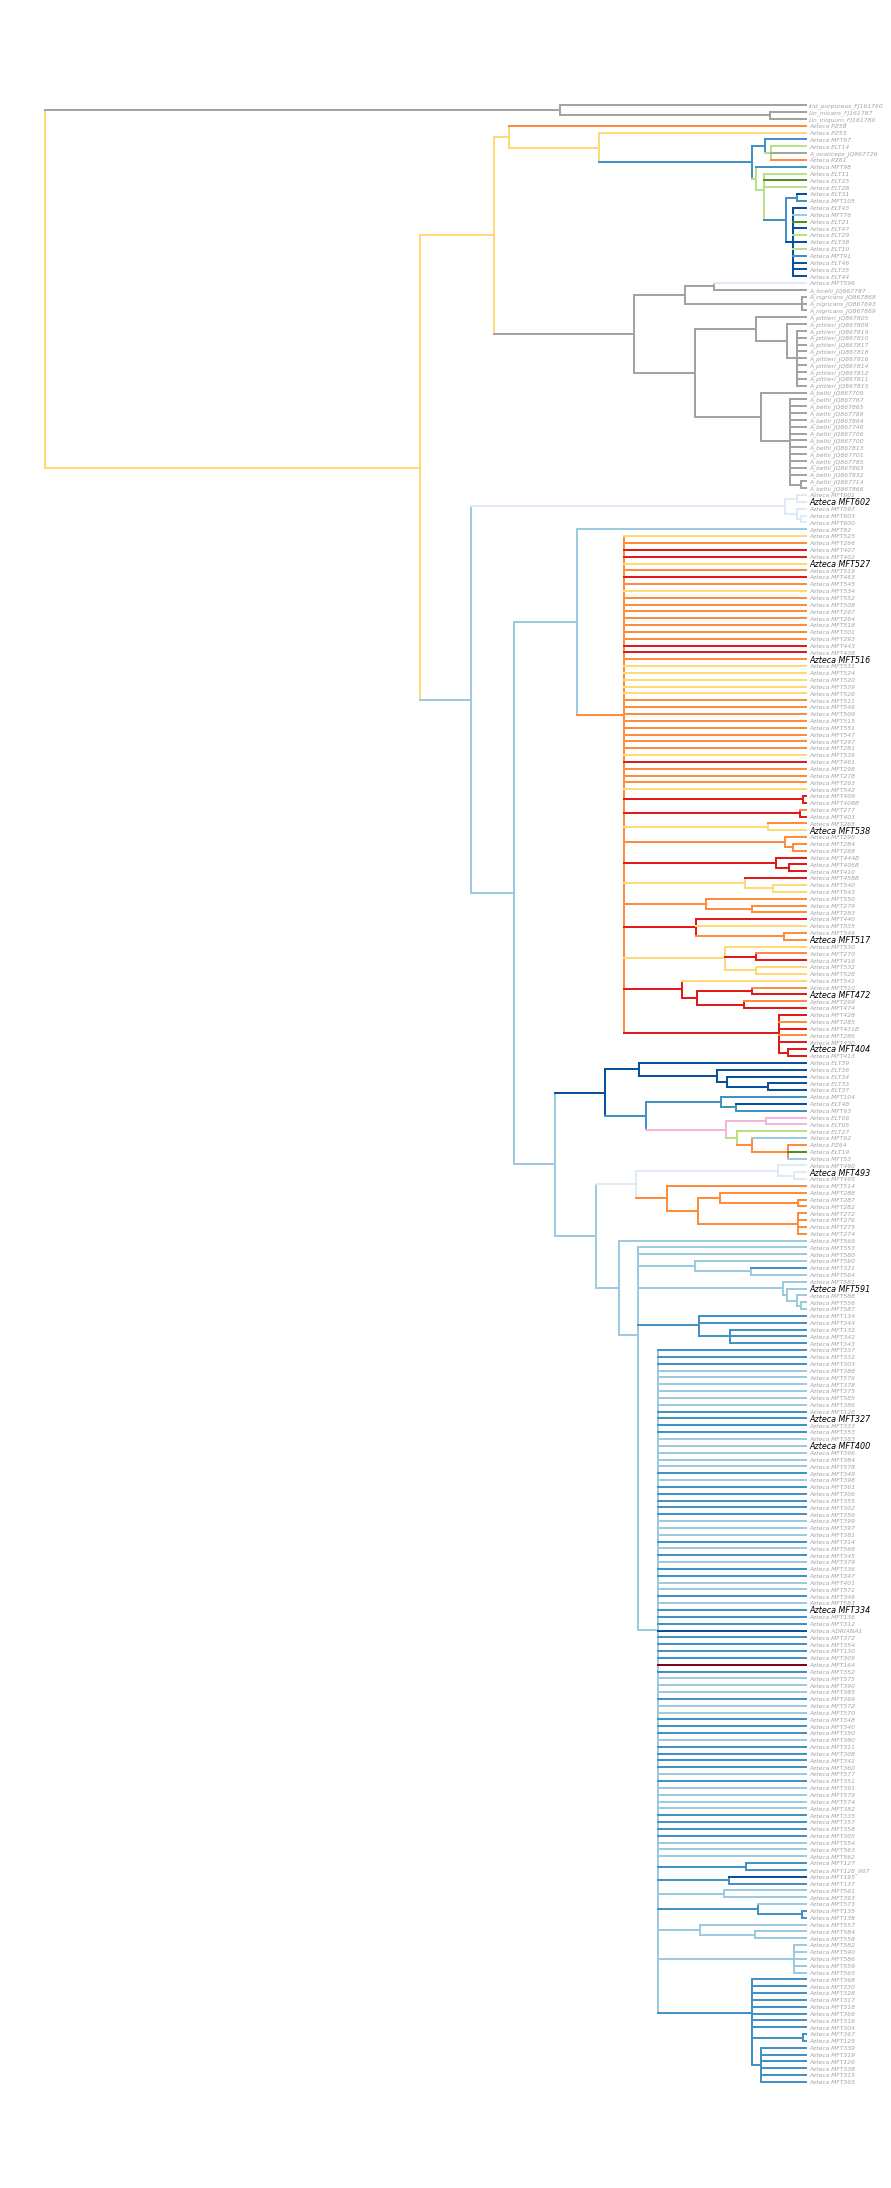

In [31]:
# Dictionaries and lists
clist=[(0.0,'#737373'),
       (1.0,'#ffffff')]

cmap=mpl.colors.LinearSegmentedColormap.from_list('mycmap',clist)
# setting lists and dictionaries:
# all locations
locations=list(data['Locality'].unique())
# to add a space between locations within a single area (for the ancestral area reconstruction)
# dictionary of areas:colour for the ancestral area reconstructions
area_dict_col={'Santander':'#deebf7','Choco':'#08519c','Valle del Cauca':'#4292c6','Antioquia':'#9ecae1', # west
               'Casanare':'#fed976','Meta':'#fd8d3c','Putumayo':'#e31a1c','Amazonas':'#800026', # east
               'Cundinamarca':'#f1b6da', # East Magdalena river but west to Eastern Cordillera
               'Tolima':'#b8e186', # West Magdalena river and west to Eastern Cordillera
               'Quindio':'#4d9221',
                'none':'#a3a3a3'} # west
area_dict_RASP={'Santander':'G','Choco':'C','Valle del Cauca':'A','Antioquia':'E', # west
               'Casanare':'H','Meta':'D','Putumayo':'F','Amazonas':'B', # east
               'Cundinamarca':'K', # East Magdalena river but west to Eastern Cordillera
               'Tolima':'I', # West Magdalena river and west to Eastern Cordillera
               'Quindio':'J',
                'none':'N'} # west
                
area_dict={'Barrancabermeja':'Santander','Cimitarra':'Santander',
           'Anolaima':'Cundinamarca',
           'Payande':'Tolima','Cocora':'Tolima','Padua':'Tolima','Mariquita':'Tolima','Espinal':'Tolima','Guayabal':'Tolima',
           'Calarca':'Quindio','Quimbaya':'Quindio','Manizales':'Quindio',
           'Arusi':'Choco','Solano':'Choco',
           'Buenaventura':'Valle del Cauca','Calima':'Valle del Cauca','Cali':'Valle del Cauca','El Cerrito':'Valle del Cauca','Jamundi':'Valle del Cauca',
           'San Carlos':'Antioquia','San Luis':'Antioquia','Amalfi':'Antioquia','Yolombo':'Antioquia','Valdivia':'Antioquia','Barbosa':'Antioquia',
          'Tauramena':'Casanare','Villanueva':'Casanare','San Luis de Gaceno':'Casanare',
           'Villavicencio':'Meta','Acacías':'Meta','S.J. de Arama':'Meta','Barranca de Upia':'Meta','Puerto Gaitan':'Meta',
           'Villagarzon':'Putumayo',
           'Leticia':'Amazonas','Puerto Nariño':'Amazonas',
            'none':'none'}

genomics=['MFT146','MFT151','MFT162','MFT327','MFT334','MFT400','MFT404','MFT472','MFT493','MFT516','MFT517','MFT527','MFT538','MFT591','MFT602']

# adding numbers
loc_tuples=[(index+1,loc) for index,loc in enumerate(locations)]
# dictionary ant genera:colour
ant_dict=colourDict(sorted(datatococa['Ant'].unique(), key=str.lower, reverse=False),cmap=mpl.cm.tab20b)
# dictionary location:location number
loc_num_dict=dict(zip([x[1] for x in loc_tuples],[x[0] for x in loc_tuples]))

# dictionary of tree_tip:locality
# make sure k.name corresponds to the info in data['Collection']
tiplocal_dict=dict(zip(data['Collection'],data['Locality']))
tiplocal_dict['none']='#a3a3a3'

# display name dictionary
tipdisplay_dict=dict(zip(data['Collection'],['%s %s'%(row.Ant,row.Collection) for row in data.itertuples()]))

# dictionary ant:plant
antplant_dict=dict(zip(data['Collection'],data['Plant']))

# annotate the Azteca tree nodes with the region
for k in anttree.Objects:
    if isinstance(k,bt.leaf): # iterates through the tip
        cur_node=k
        while cur_node:
            cur_node.traits['locality']=tiplocal_dict[k.name] if k.name in tiplocal_dict.keys() else 'none' # annotates the parental nodes with the genus name. Done for colouring the branches based on genera
            cur_node=cur_node.parent

fig,ax = plt.subplots(figsize=(15,40),facecolor='w')

atree=anttree.collapseBranches(lambda k: 'posterior' not in k.traits or k.traits['posterior'] <= 0.5)
x_attr=lambda k: k.x-atree.treeHeight if k.x else -atree.treeHeight
# x_attr=lambda k: k.x
bc_func=lambda k: area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3' # Uses the colour dictionaries above and colours the branches based on genera
# bc_func=lambda k:'k'
b_func=lambda k: 2 ## branch width function
s_func=lambda k: 6-3*k.height/atree.treeHeight ## size of tips
# s_func=lambda k: 1 ## size of tips
z_func=lambda k: 10

atree.plotTree(ax,x_attr=x_attr,colour=bc_func,width=b_func) ## plot branches

for k in atree.Objects:
    if isinstance(k,bt.leaf) or k.branchType=='leaf':
        if k.name in genomics:
            ax.text(k.x-atree.treeHeight+0.2,k.y,'%s'%(tipdisplay_dict[k.name] if k.name in tipdisplay_dict.keys() else k.name),
                    va='center', ha='left',size=8, color='k', style='italic')
        else:
            ax.text(k.x-atree.treeHeight+0.2,k.y,'%s'%(tipdisplay_dict[k.name] if k.name in tipdisplay_dict.keys() else k.name),
                    va='center', ha='left',size=6, color='#a3a3a3', style='italic')
#     else:
#         print(area_dict_col[area_dict[k.traits['locality']]] if 'locality' in k.traits else '#a3a3a3')
#         if 'posterior' in k.traits and k.traits['posterior'] < 0.99:
#             ax.text(k.height-atree.treeHeight-0.2,k.y-0.25,'%1.2f'%(k.traits['posterior'] if 'posterior' in k.traits else ''),va='top',ha='right',size=8,color='#545454',zorder=1000)
#             ax.text(k.height-0.001,k.y-0.16,'*',va='top',ha='right',size=28,color='#303030',zorder=1000)
#         if  'height_95%_HPD' in k.traits:
#             height=0.5
#             left=-k.traits['height_95%_HPD'][1]  # past to present
#             bottom=k.y-(height/2) ## max-median
#             width=(k.traits['height_95%_HPD'][1])-(k.traits['height_95%_HPD'][0]) # max-min 
#             box=plt.Rectangle((left,bottom),width,height,facecolor='#bababa',edgecolor='none',alpha=0.4)
#             ax.add_patch(box)
#         ax.text(k.x-atree.treeHeight+0.1,k.y,'%s'%(k.index),va='center', ha='left',size=8,color='b') # node index, to be able to flip the clades for the map
ax.plot()
# ax.set_ylim(-5,atree.ySpan+5)
# ax.set_xlim(-0.1,0.5)
# xlinebar=0.1175
# ax.text(xlinebar+0.025,49,'0.05',va='top',ha='center',size=25,color='#303030')
# ax.hlines(50,xlinebar,xlinebar+0.05,linestyle='solid',color='#c2c2c2',lw=4) 

plt.xticks([])
plt.yticks([])
    
[ax.spines[loc].set_visible(False) for loc in ax.spines]


# plt.savefig('./Azteca_mcct_20210106.pdf',pdi=300)

plt.show()
